<a href="https://colab.research.google.com/github/datagrad/Kamal-Thesis-Work/blob/main/ARISMA_for_PM2_5_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARISMA model for Validation

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv"
df = pd.read_csv(url)

# Convert 'Date' column to datetime format

df['Date'] = pd.to_datetime(df['Date'])


In [3]:
selected_cities = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(selected_cities)]

# Retain only 'City', 'Date', and 'PM2.5' columns
df = df[['City', 'Date', 'PM2.5']]
df

,City,Date,PM2.5
1,Bengaluru,2015-01-01,NaN
3,Delhi,2015-01-01,313.22
7,Bengaluru,2015-01-02,NaN
9,Delhi,2015-01-02,186.18
13,Bengaluru,2015-01-03,NaN
...,...,...,...
29489,Delhi,2020-06-30,39.80
29493,Hyderabad,2020-06-30,19.38
29509,Bengaluru,2020-07-01,17.50
29515,Delhi,2020-07-01,54.01


In [4]:
data_types = df.dtypes
print(data_types)

City             object
Date     datetime64[ns]
PM2.5           float64
dtype: object


In [5]:
# Find NaN values for each city in the 'PM2.5' column
nan_values_by_city = df[df['PM2.5'].isnull()].groupby('City').size()
print("NaN values for PM2.5 by city:")
print(nan_values_by_city)

NaN values for PM2.5 by city:
City
Bengaluru    146
Delhi          2
Hyderabad    115
dtype: int64


In [6]:
# NAN value imputation

# Replace NaN values in the 'PM2.5' column with next day's value (forward fill) for each city
df['PM2.5'] = df.groupby('City')['PM2.5'].fillna(method='ffill')

In [7]:
# Filter rows with NaN values in the 'PM2.5' column
rows_with_nan_pm25 = df[df['PM2.5'].isnull()]

# Display all the rows with NaN values in the 'PM2.5' column

rows_with_nan_pm25


,City,Date,PM2.5
1,Bengaluru,2015-01-01,NaN
7,Bengaluru,2015-01-02,NaN
13,Bengaluru,2015-01-03,NaN
19,Bengaluru,2015-01-04,NaN
22,Hyderabad,2015-01-04,NaN
...,...,...,...
589,Hyderabad,2015-03-26,NaN
596,Hyderabad,2015-03-27,NaN
603,Hyderabad,2015-03-28,NaN
610,Hyderabad,2015-03-29,NaN


These are NAN values of starting period and hence can be dropped for accuracy

In [8]:
# Drop rows with NaN values in the 'PM2.5' column
df.dropna(subset=['PM2.5'], inplace=True)

In [9]:
df

,City,Date,PM2.5
3,Delhi,2015-01-01,313.22
9,Delhi,2015-01-02,186.18
15,Delhi,2015-01-03,87.18
21,Delhi,2015-01-04,151.84
28,Delhi,2015-01-05,146.60
...,...,...,...
29489,Delhi,2020-06-30,39.80
29493,Hyderabad,2020-06-30,19.38
29509,Bengaluru,2020-07-01,17.50
29515,Delhi,2020-07-01,54.01


In [10]:
# Sort the DataFrame by the 'Date' column in ascending order
df = df.sort_values(by='Date')

In [11]:
df

,City,Date,PM2.5
3,Delhi,2015-01-01,313.22
9,Delhi,2015-01-02,186.18
15,Delhi,2015-01-03,87.18
21,Delhi,2015-01-04,151.84
28,Delhi,2015-01-05,146.60
...,...,...,...
29483,Bengaluru,2020-06-30,14.47
29493,Hyderabad,2020-06-30,19.38
29515,Delhi,2020-07-01,54.01
29509,Bengaluru,2020-07-01,17.50


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


In [13]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.sort_values(by='Date', inplace=True)


In [14]:
city_name = 'Delhi'
df_delhi = df[df['City'] == city_name].copy()


In [15]:
df_delhi.set_index('Date', inplace=True)
pm25_series = df_delhi['PM2.5']


In [16]:
# Split the data into training and testing sets
train_size = int(len(pm25_series) * 0.8)  # 80% for training
train_data, test_data = pm25_series[:train_size], pm25_series[train_size:]


In [17]:
# Define the ARIMA model with (p, d, q) parameters
p, d, q = 1, 1, 1
model = ARIMA(train_data, order=(p, d, q))

# Fit the model
results = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [18]:
# Forecast the next steps in the test data
forecast_steps = len(test_data)
forecast = results.forecast(steps=forecast_steps)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate the performance metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 52.65
Mean Squared Error (MSE): 6701.93
Root Mean Squared Error (RMSE): 81.87
Mean Absolute Percentage Error (MAPE): 71.13%


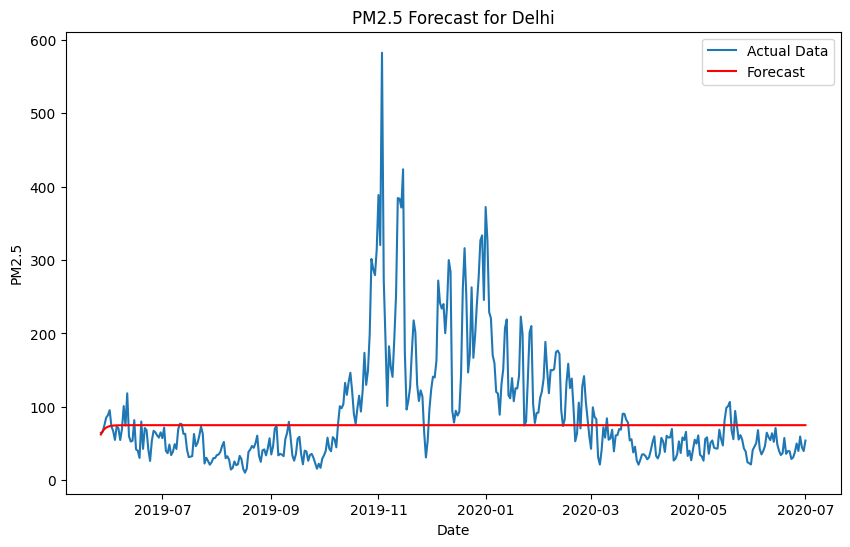

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df_delhi.index[-len(test_data):], test_data, label='Actual Data')
plt.plot(df_delhi.index[-len(test_data):], forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title(f'PM2.5 Forecast for {city_name}')
plt.legend()
plt.show()


# Only Prediction Using Arisma

In [21]:
import pandas as pd
import numpy as np

In [22]:

# Load the dataset
url = "https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv"
df = pd.read_csv(url)

# Convert 'Date' column to datetime format

df['Date'] = pd.to_datetime(df['Date'])



In [23]:
selected_cities = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(selected_cities)]

# Retain only 'City', 'Date', and 'PM2.5' columns
df = df[['City', 'Date', 'PM2.5']]
df

,City,Date,PM2.5
1,Bengaluru,2015-01-01,NaN
3,Delhi,2015-01-01,313.22
7,Bengaluru,2015-01-02,NaN
9,Delhi,2015-01-02,186.18
13,Bengaluru,2015-01-03,NaN
...,...,...,...
29489,Delhi,2020-06-30,39.80
29493,Hyderabad,2020-06-30,19.38
29509,Bengaluru,2020-07-01,17.50
29515,Delhi,2020-07-01,54.01


In [24]:
data_types = df.dtypes
print(data_types)

City             object
Date     datetime64[ns]
PM2.5           float64
dtype: object


In [25]:
# Find NaN values for each city in the 'PM2.5' column
nan_values_by_city = df[df['PM2.5'].isnull()].groupby('City').size()
print("NaN values for PM2.5 by city:")
print(nan_values_by_city)

NaN values for PM2.5 by city:
City
Bengaluru    146
Delhi          2
Hyderabad    115
dtype: int64


In [26]:
# NAN value imputation

# Replace NaN values in the 'PM2.5' column with next day's value (forward fill) for each city
df['PM2.5'] = df.groupby('City')['PM2.5'].fillna(method='ffill')

In [27]:
# Filter rows with NaN values in the 'PM2.5' column
rows_with_nan_pm25 = df[df['PM2.5'].isnull()]

# Display all the rows with NaN values in the 'PM2.5' column

rows_with_nan_pm25


,City,Date,PM2.5
1,Bengaluru,2015-01-01,NaN
7,Bengaluru,2015-01-02,NaN
13,Bengaluru,2015-01-03,NaN
19,Bengaluru,2015-01-04,NaN
22,Hyderabad,2015-01-04,NaN
...,...,...,...
589,Hyderabad,2015-03-26,NaN
596,Hyderabad,2015-03-27,NaN
603,Hyderabad,2015-03-28,NaN
610,Hyderabad,2015-03-29,NaN


These are NAN values of starting period and hence can be dropped for accuracy

In [28]:
# Drop rows with NaN values in the 'PM2.5' column
df.dropna(subset=['PM2.5'], inplace=True)

In [29]:
df

,City,Date,PM2.5
3,Delhi,2015-01-01,313.22
9,Delhi,2015-01-02,186.18
15,Delhi,2015-01-03,87.18
21,Delhi,2015-01-04,151.84
28,Delhi,2015-01-05,146.60
...,...,...,...
29489,Delhi,2020-06-30,39.80
29493,Hyderabad,2020-06-30,19.38
29509,Bengaluru,2020-07-01,17.50
29515,Delhi,2020-07-01,54.01


In [30]:
# Sort the DataFrame by the 'Date' column in ascending order
df = df.sort_values(by='Date')

In [31]:
df

,City,Date,PM2.5
3,Delhi,2015-01-01,313.22
9,Delhi,2015-01-02,186.18
15,Delhi,2015-01-03,87.18
21,Delhi,2015-01-04,151.84
28,Delhi,2015-01-05,146.60
...,...,...,...
29483,Bengaluru,2020-06-30,14.47
29493,Hyderabad,2020-06-30,19.38
29515,Delhi,2020-07-01,54.01
29509,Bengaluru,2020-07-01,17.50


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


In [33]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.sort_values(by='Date', inplace=True)


In [34]:
city_name = 'Delhi'
df_delhi = df[df['City'] == city_name].copy()


In [35]:
df_delhi.set_index('Date', inplace=True)
pm25_series = df_delhi['PM2.5']


In [36]:
# Define the ARIMA model with (p, d, q) parameters
p, d, q = 1, 1, 1
model = ARIMA(pm25_series, order=(p, d, q))

# Fit the model
results = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
# Forecast the next 180 days
forecast_steps = 360
forecast = results.forecast(steps=forecast_steps)



<ipython-input-38-b0c3e71c8993>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=df_delhi.index[-1], periods=forecast_steps + 1, closed='right')


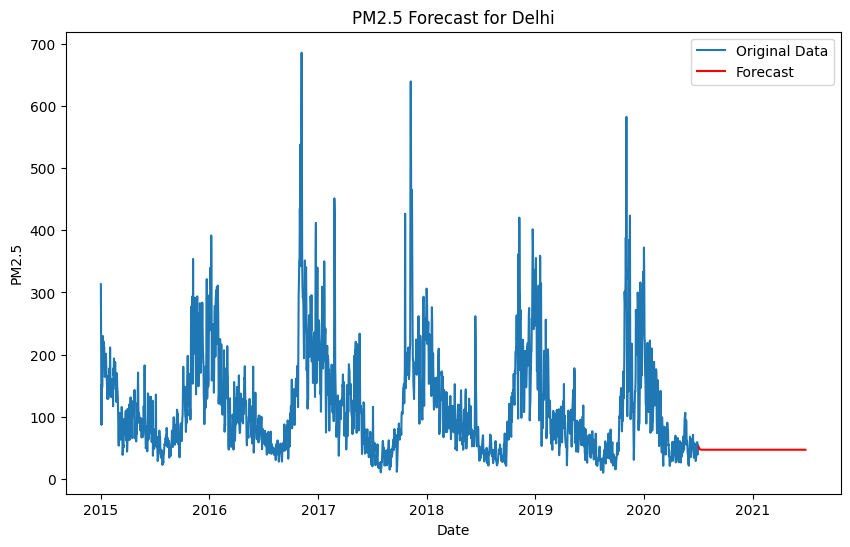

In [38]:
# Create a date range for the forecast
forecast_dates = pd.date_range(start=df_delhi.index[-1], periods=forecast_steps + 1, closed='right')

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_delhi.index, pm25_series, label='Original Data')
plt.plot(forecast_dates.shift(1), forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title(f'PM2.5 Forecast for {city_name}')
plt.legend()
plt.show()


# SARIMA

The basic ARIMA model does not explicitly capture seasonal patterns. To compensate for seasonal changes, we can use **Seasonal Autoregressive Integrated Moving Average (SARIMA)** or other seasonal time series models.

SARIMA extends the ARIMA model by introducing additional seasonal parameters to handle seasonality. It includes three additional parameters: P (seasonal autoregressive order), D (seasonal differencing order), and Q (seasonal moving average order). SARIMA is particularly useful when there are clear seasonal patterns in the data.

In [39]:
import pandas as pd
import numpy as np

In [40]:
# Load the dataset
url = "https://raw.githubusercontent.com/datagrad/MS_Reference_MS-DS-LJMU-C13/main/city_day.csv"
df = pd.read_csv(url)

# Convert 'Date' column to datetime format

df['Date'] = pd.to_datetime(df['Date'])


In [41]:
selected_cities = ['Delhi', 'Bengaluru', 'Hyderabad']
df = df[df['City'].isin(selected_cities)]

# Retain only 'City', 'Date', and 'PM2.5' columns
df = df[['City', 'Date', 'PM2.5']]
df

,City,Date,PM2.5
1,Bengaluru,2015-01-01,NaN
3,Delhi,2015-01-01,313.22
7,Bengaluru,2015-01-02,NaN
9,Delhi,2015-01-02,186.18
13,Bengaluru,2015-01-03,NaN
...,...,...,...
29489,Delhi,2020-06-30,39.80
29493,Hyderabad,2020-06-30,19.38
29509,Bengaluru,2020-07-01,17.50
29515,Delhi,2020-07-01,54.01


In [42]:
data_types = df.dtypes
print(data_types)

City             object
Date     datetime64[ns]
PM2.5           float64
dtype: object


In [43]:
# Find NaN values for each city in the 'PM2.5' column
nan_values_by_city = df[df['PM2.5'].isnull()].groupby('City').size()
print("NaN values for PM2.5 by city:")
print(nan_values_by_city)

NaN values for PM2.5 by city:
City
Bengaluru    146
Delhi          2
Hyderabad    115
dtype: int64


In [44]:
# NAN value imputation

# Replace NaN values in the 'PM2.5' column with next day's value (forward fill) for each city
df['PM2.5'] = df.groupby('City')['PM2.5'].fillna(method='ffill')

In [45]:
# Filter rows with NaN values in the 'PM2.5' column
rows_with_nan_pm25 = df[df['PM2.5'].isnull()]

# Display all the rows with NaN values in the 'PM2.5' column

rows_with_nan_pm25


,City,Date,PM2.5
1,Bengaluru,2015-01-01,NaN
7,Bengaluru,2015-01-02,NaN
13,Bengaluru,2015-01-03,NaN
19,Bengaluru,2015-01-04,NaN
22,Hyderabad,2015-01-04,NaN
...,...,...,...
589,Hyderabad,2015-03-26,NaN
596,Hyderabad,2015-03-27,NaN
603,Hyderabad,2015-03-28,NaN
610,Hyderabad,2015-03-29,NaN


These are NAN values of starting period and hence can be dropped for accuracy

In [46]:
# Drop rows with NaN values in the 'PM2.5' column
df.dropna(subset=['PM2.5'], inplace=True)

In [47]:
df

,City,Date,PM2.5
3,Delhi,2015-01-01,313.22
9,Delhi,2015-01-02,186.18
15,Delhi,2015-01-03,87.18
21,Delhi,2015-01-04,151.84
28,Delhi,2015-01-05,146.60
...,...,...,...
29489,Delhi,2020-06-30,39.80
29493,Hyderabad,2020-06-30,19.38
29509,Bengaluru,2020-07-01,17.50
29515,Delhi,2020-07-01,54.01


In [48]:
# Sort the DataFrame by the 'Date' column in ascending order
df = df.sort_values(by='Date')

In [49]:
df

,City,Date,PM2.5
3,Delhi,2015-01-01,313.22
9,Delhi,2015-01-02,186.18
15,Delhi,2015-01-03,87.18
21,Delhi,2015-01-04,151.84
28,Delhi,2015-01-05,146.60
...,...,...,...
29483,Bengaluru,2020-06-30,14.47
29493,Hyderabad,2020-06-30,19.38
29515,Delhi,2020-07-01,54.01
29509,Bengaluru,2020-07-01,17.50


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


In [51]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.sort_values(by='Date', inplace=True)


In [52]:
city_name = 'Delhi'
df_delhi = df[df['City'] == city_name].copy()


In [53]:
df_delhi.set_index('Date', inplace=True)
pm25_series = df_delhi['PM2.5']


In [54]:
# Split the data into training and testing sets
train_size = int(len(pm25_series) * 0.8)  # 80% for training
train_data, test_data = pm25_series[:train_size], pm25_series[train_size:]


In [55]:
# Define the ARIMA model with (p, d, q) parameters
p, d, q = 1, 1, 1
model = ARIMA(train_data, order=(p, d, q))

# Fit the model
results = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
# Define the SARIMA model with (p, d, q) and (P, D, Q, s) parameters
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 5, 1, 1, 7  # Seasonal parameters (assuming a daily seasonal pattern)

model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model
results = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
# Forecast the next steps in the test data
forecast_steps = len(test_data)
forecast = results.forecast(steps=forecast_steps)

# Calculate the performance metrics (MAE, MSE, RMSE, MAPE) and plot the results
# (same as before)


In [ ]:
# Forecast the next 180 days
forecast_steps = 360
forecast = results.forecast(steps=forecast_steps)



In [ ]:
# Create a date range for the forecast
forecast_dates = pd.date_range(start=df_delhi.index[-1], periods=forecast_steps + 1, closed='right')

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_delhi.index, pm25_series, label='Original Data')
plt.plot(forecast_dates.shift(1), forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title(f'PM2.5 Forecast for {city_name}')
plt.legend()
plt.show()
